Installing pre-requisites

In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 102kB 5.4MB/s 
     |████████████████████████████████| 89.4MB 54kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## PART 1: Importing datasets (both training and MNIST)

In [3]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
transform = transforms.Compose(
    [transforms.Resize(220),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])])

In [5]:
from torchvision import datasets
mnistTest = datasets.MNIST('.', train=False, download=True, transform=transform)
mnistTestLoader = torch.utils.data.DataLoader(mnistTest, batch_size=128)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
!unzip /content/drive/MyDrive/MIDAS/TASK3/mnistTask3.zip -d /content/mnistTASK

Streaming output truncated to the last 5000 lines.
 extracting: /content/mnistTASK/mnistTask/3/image_021488.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_047540.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_050475.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_024391.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_020193.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_004447.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_051601.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_009900.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_020916.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_025962.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_054889.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_012369.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_025528.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_035609.jpg  
 extracting: /content/mnistTASK/mnistTask/3/image_037469.jpg  
 ext

In [9]:
pathToDataset = '/content/mnistTASK/mnistTask'

In [10]:
imagePath = []
labels = []
for folder in os.listdir(pathToDataset):
    for images in os.listdir(os.path.join(pathToDataset,folder)):
        image = os.path.join(pathToDataset,folder,images)
        imagePath.append(image)
        labels.append(folder)
data = {'Images':imagePath, 'Labels':labels}
data = pd.DataFrame(data)
data.head()

,Images,Labels
0,/content/mnistTASK/mnistTask/4/image_044548.jpg,4
1,/content/mnistTASK/mnistTask/4/image_002442.jpg,4
2,/content/mnistTASK/mnistTask/4/image_007931.jpg,4
3,/content/mnistTASK/mnistTask/4/image_048121.jpg,4
4,/content/mnistTASK/mnistTask/4/image_025016.jpg,4


In [11]:
labelEncoder = LabelEncoder()
data['Encoded Labels'] = labelEncoder.fit_transform(data['Labels'])
data.head()

,Images,Labels,Encoded Labels
0,/content/mnistTASK/mnistTask/4/image_044548.jpg,4,4
1,/content/mnistTASK/mnistTask/4/image_002442.jpg,4,4
2,/content/mnistTASK/mnistTask/4/image_007931.jpg,4,4
3,/content/mnistTASK/mnistTask/4/image_048121.jpg,4,4
4,/content/mnistTASK/mnistTask/4/image_025016.jpg,4,4


In [12]:
batchSize = 128
validationSplit = 0.15
shuffleDataset = True
randomSeed = 17

In [13]:
datasetSize = len(data)
indices = list(range(datasetSize))
split = int(np.floor(validationSplit*datasetSize))
if shuffleDataset:
    np.random.seed(randomSeed)
    np.random.shuffle(indices)
trainIndices, validationIndices = indices[split:], indices[:split]

In [14]:
trainSampler = SubsetRandomSampler(trainIndices)
validationSampler = SubsetRandomSampler(validationIndices)

In [15]:
class CustomDataset(Dataset):
    def __init__(self, imageData, imagePath, transform=None):
        self.imagePath = imagePath
        self.imageData = imageData
        self.transform = transform
    def __len__(self):
        return len(self.imageData)
    def __getitem__(self, index):
        imageName = os.path.join(self.imagePath, self.imageData.loc[index, 'Labels'],self.imageData.loc[index,'Images'])
        image = Image.open(imageName).convert('L')
        image = image.resize((32,32))
        label = torch.tensor(self.imageData.loc[index, 'Encoded Labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image,label

In [16]:
dataset = CustomDataset(data,pathToDataset,transform)

In [17]:
trainLoader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, sampler = trainSampler)
validationLoader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, sampler = validationSampler)

In [18]:
def  displayImage(image):
    image = image/2 + 0.5
    image = image.numpy()
    image = image.reshape(220,220)
    return image

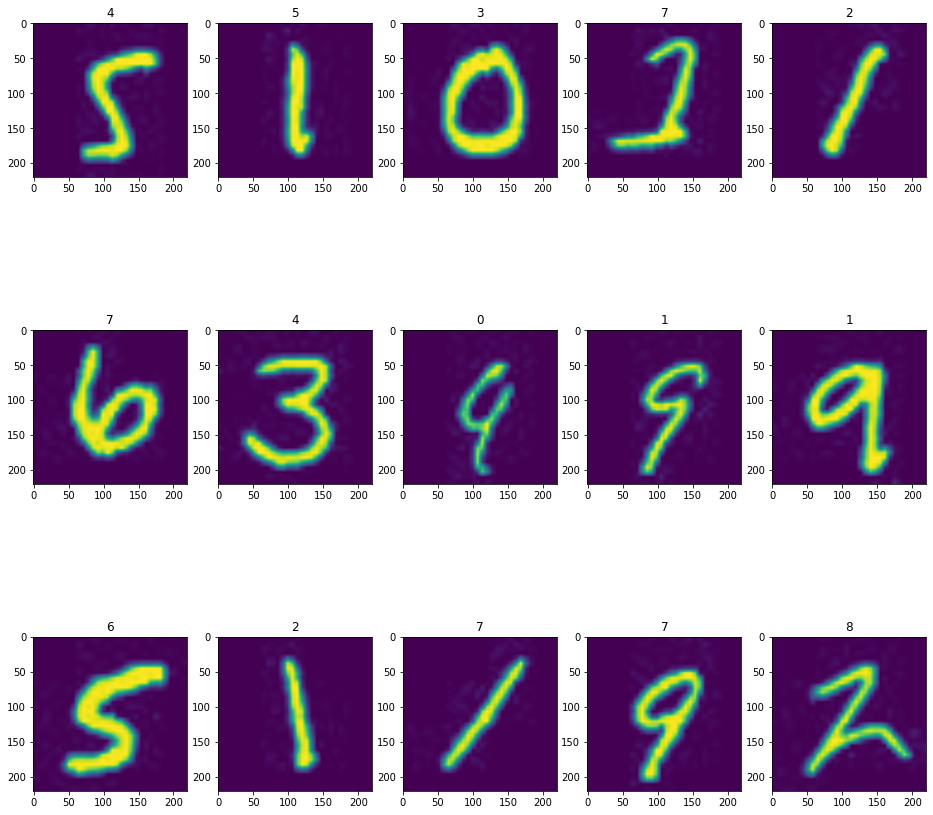

In [19]:
dataIterator = iter(trainLoader)
images, labels = dataIterator.next()
figure, axis = plt.subplots(3,5, figsize=(16,16))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(displayImage(image))
        ax.set(title=f"{label.item()}")

## Part 2: Training from scratch and testing on MNIST

In [20]:
#the pytorch metric learning library comes with inbuilt methods for triplet mining and computing triplet losses between anchor, positive class and negative class
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training the model on: ",device, " Available GPU: ", torch.cuda.get_device_name(0))

Training the model on:  cuda:0  Available GPU:  Tesla T4


In [22]:
class EmbeddingNetwork(nn.Module):
    def __init__(self):
        super(EmbeddingNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, (7,7), stride=(2,2), padding=(3,3)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3, 3), 2, padding=(1,1))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,64,(1,1), stride=(1,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.001),
            nn.Conv2d(64,192, (3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3),2, padding=(1,1))
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192,192,(1,1), stride=(1,1)),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.001),
            nn.Conv2d(192,384,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3), 2, padding=(1,1))
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384,384,(1,1), stride=(1,1)),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.001),
            nn.Conv2d(384,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256,256,(1,1), stride=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.Conv2d(256,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256,256,(1,1), stride=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.Conv2d(256,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3),2, padding=(1,1)),
            nn.Flatten()
        )
        self.fullyConnected = nn.Sequential(
            nn.Linear(7*7*256,32*128),
            nn.BatchNorm1d(32*128),
            nn.LeakyReLU(0.001),
            nn.Linear(32*128,128)
        )
    def forward(self,x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.fullyConnected(x)
      return torch.nn.functional.normalize(x, p=2, dim=-1)

In [23]:
embeddingNetwork = EmbeddingNetwork().to(device)
print(embeddingNetwork)

EmbeddingNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.001)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.001)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.001)
    (6): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affin

In [28]:
def train(model, lossFunction, miningFunction, device, trainLoader, optimizer, epoch):
    print("Training started for Epoch: ",epoch)
    model.train()
    for batchIndex, (data, labels) in enumerate(trainLoader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        hardPairs = miningFunction(embeddings, labels)
        loss = lossFunction(embeddings, labels, hardPairs)
        loss.backward()
        optimizer.step()
        if batchIndex%200==0:
            print("Training Stats for Epoch {} Iteration {}: Loss= {}, Number of mined triplets {}".format(epoch, batchIndex, loss, miningFunction.num_triplets))

In [25]:
#distance this tells the model how to calculate the distance between the  generated embeddings
distance = CosineSimilarity()
reducer = ThresholdReducer(low=0.0)
lossFunction = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
miningFunction = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semi-hard")
optimizer = torch.optim.Adam(embeddingNetwork.parameters(), lr=0.05)

The validation split here is from the given dataset not the MNIST Dataset

In [26]:
def tester(maxValidationAccuracy):
  trainEmbeddings = []
  trainLabels = []
  validationEmbeddings = []
  validationLabels = []
  with torch.no_grad():
    embeddingNetwork.eval()
    for (dataTr, labelTr) in (trainLoader):
      dataTr, labelTr = dataTr.to(device), labelTr.to(device)
      embeddingTr = embeddingNetwork(dataTr)
      trainEmbeddings.append(embeddingTr.cpu().detach().numpy())
      trainLabels.append(labelTr.cpu().detach().numpy())
    for (dataTe, labelTe) in (validationLoader):
      dataTe, labelTe = dataTe.to(device), labelTe.to(device)
      embeddingsTe = embeddingNetwork(dataTe)
      validationEmbeddings.append(embeddingsTe.cpu().detach().numpy())
      validationLabels.append(labelTe.cpu().detach().numpy())
  trainEmbeddings1 = []
  trainLabels1 = []
  validationEmbeddings1 = []
  validationLabels1 = []
  for bat in trainEmbeddings:
    for exm in bat:
      trainEmbeddings1.append(exm)
  for bat in trainLabels:
    for exm in bat:
      trainLabels1.append(exm)
  for bat in validationEmbeddings:
    for exm in bat:
      validationEmbeddings1.append(exm)
  for bat in validationLabels:
    for exm in bat:
      validationLabels1.append(exm)
  neigh = KNeighborsClassifier(n_neighbors=13)
  neigh.fit(trainEmbeddings1, trainLabels1)
  prediction = neigh.predict(validationEmbeddings1)
  currentAccuracy = accuracy_score(validationLabels1,prediction)
  print("Accuracy: ",currentAccuracy)
  if currentAccuracy > maxValidationAccuracy:
    maxValidationAccuracy = currentAccuracy
    print("New highest validation accuracy, saving the embedding model")
    torch.save(embeddingNetwork.state_dict(), "embeddingNetworkTask3.pt")
  return maxValidationAccuracy

In [29]:
maxValidationAccuracy = 0
for epoch in range(1, 81):
    train(embeddingNetwork, lossFunction, miningFunction, device, trainLoader, optimizer, epoch)
    print("Training completed for the Epoch:", epoch)
    maxValidationAccuracy = tester(maxValidationAccuracy)

Training started for Epoch:  1
Training Stats for Epoch 1 Iteration 0: Loss= 0.1997629702091217, Number of mined triplets 178104
Training Stats for Epoch 1 Iteration 200: Loss= 0.20170600712299347, Number of mined triplets 187044
Training completed for the Epoch: 1
Accuracy:  0.10888888888888888
New highest validation accuracy, saving the embedding model
Training started for Epoch:  2
Training Stats for Epoch 2 Iteration 0: Loss= 0.2016572803258896, Number of mined triplets 181469
Training Stats for Epoch 2 Iteration 200: Loss= 0.19994910061359406, Number of mined triplets 179976
Training completed for the Epoch: 2
Accuracy:  0.10444444444444445
Training started for Epoch:  3
Training Stats for Epoch 3 Iteration 0: Loss= 0.20570774376392365, Number of mined triplets 181526
Training Stats for Epoch 3 Iteration 200: Loss= 0.20115132629871368, Number of mined triplets 186864
Training completed for the Epoch: 3
Accuracy:  0.10966666666666666
New highest validation accuracy, saving the embe

In [30]:
print("Highest Validation Accuracy acheived during training: ", maxValidationAccuracy)

Highest Validation Accuracy acheived during training:  0.11688888888888889


In [31]:
#loading best validated weights into the classifier
embeddingNetwork = EmbeddingNetwork().to(device)
embeddingNetwork.load_state_dict(torch.load('embeddingNetworkTask3.pt'))

<All keys matched successfully>

In [32]:
class classifierNet(nn.Module):
    def __init__(self, EmbeddingNet):
        super(classifierNet, self).__init__()
        self.embeddingLayer = EmbeddingNet
        self.linearLayer = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.classifierLayer = nn.Linear(64,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(self.embeddingLayer(x))
        x = self.dropout(self.linearLayer(x))
        x = self.classifierLayer(x)
        return F.log_softmax(x, dim=1)

In [38]:
classifier = classifierNet(embeddingNetwork).to(device)
print(classifier)

classifierNet(
  (embeddingLayer): EmbeddingNetwork(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.001)
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.001)
      (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.001)
      (6): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(192, 192, kernel_size=(1, 1), st

In [39]:
for param in classifier.embeddingLayer.parameters():
    param.requires_grad = False

The code below trains the classifier on provided dataset and tests on MNIST dataset. Here the validation accuracy means the accuracy of the MNIST test set.

In [40]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)

In [41]:
numberOfEpochs = 15
validAccuracyMax = 0.0
validationLossTransfer = []
validationAccuracyTransfer = []
trainingLossTransfer = []
trainingAccuracyTransfer = []
totalSteps = len(trainLoader)
for epoch in range(1, numberOfEpochs):
    classifier.train()
    runningLoss = 0.0
    correct = 0
    total = 0
    print("Training started for Epoch: ",epoch)
    for batchIndex, (data, target) in enumerate(trainLoader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = classifier(data)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        if (batchIndex)%100 ==0:
            print("Epoch [{}/{}] Step [{}/{}] Loss: {:.4f}".format(epoch,numberOfEpochs,batchIndex,totalSteps,loss.item()))
    trainingAccuracyTransfer.append(100*correct/total)
    trainingLossTransfer.append(runningLoss/totalSteps)
    print("Training Accuracy: ",(100*correct/total))
    batchLoss = 0
    totalV = 0
    correctV = 0
    with torch.no_grad():
        classifier.eval()
        for dataV, targetV in (mnistTestLoader):
            dataV, targetV = dataV.to(device), targetV.to(device)
            outputV = classifier(dataV)
            lossV = criterion(outputV,targetV)
            batchLoss += lossV.item()
            _, predV = torch.max(outputV, dim=1)
            correctV += torch.sum(predV==targetV).item()
            totalV += targetV.size(0)
        validationAccuracyTransfer.append(100*correctV/totalV)
        validationLossTransfer.append(batchLoss/len(mnistTestLoader))
        print("Validation Accuracy: ",(100*correctV/totalV))
        if (100*correctV/totalV)>validAccuracyMax:
          validAccuracyMax = 100*correctV/totalV
          print("Validation accuracy improved, network improvement detected, saving network")
          torch.save(classifier.state_dict(), "mnistFinalWeightsTASK3.pt")

    classifier.train()

Training started for Epoch:  1
Epoch [1/15] Step [0/399] Loss: 2.3080
Epoch [1/15] Step [100/399] Loss: 2.2780
Epoch [1/15] Step [200/399] Loss: 2.3058
Epoch [1/15] Step [300/399] Loss: 2.2850
Training Accuracy:  11.494117647058824
Validation Accuracy:  0.39
Validation accuracy improved, network improvement detected, saving network
Training started for Epoch:  2
Epoch [2/15] Step [0/399] Loss: 2.2832
Epoch [2/15] Step [100/399] Loss: 2.3016
Epoch [2/15] Step [200/399] Loss: 2.2752
Epoch [2/15] Step [300/399] Loss: 2.2667
Training Accuracy:  11.341176470588236
Validation Accuracy:  0.27
Training started for Epoch:  3
Epoch [3/15] Step [0/399] Loss: 2.2738
Epoch [3/15] Step [100/399] Loss: 2.2906
Epoch [3/15] Step [200/399] Loss: 2.2339
Epoch [3/15] Step [300/399] Loss: 2.2615
Training Accuracy:  11.129411764705882
Validation Accuracy:  0.56
Validation accuracy improved, network improvement detected, saving network
Training started for Epoch:  4
Epoch [4/15] Step [0/399] Loss: 2.2686
Epo

Plotting the Accuracy and Loss on the MNIST Test set

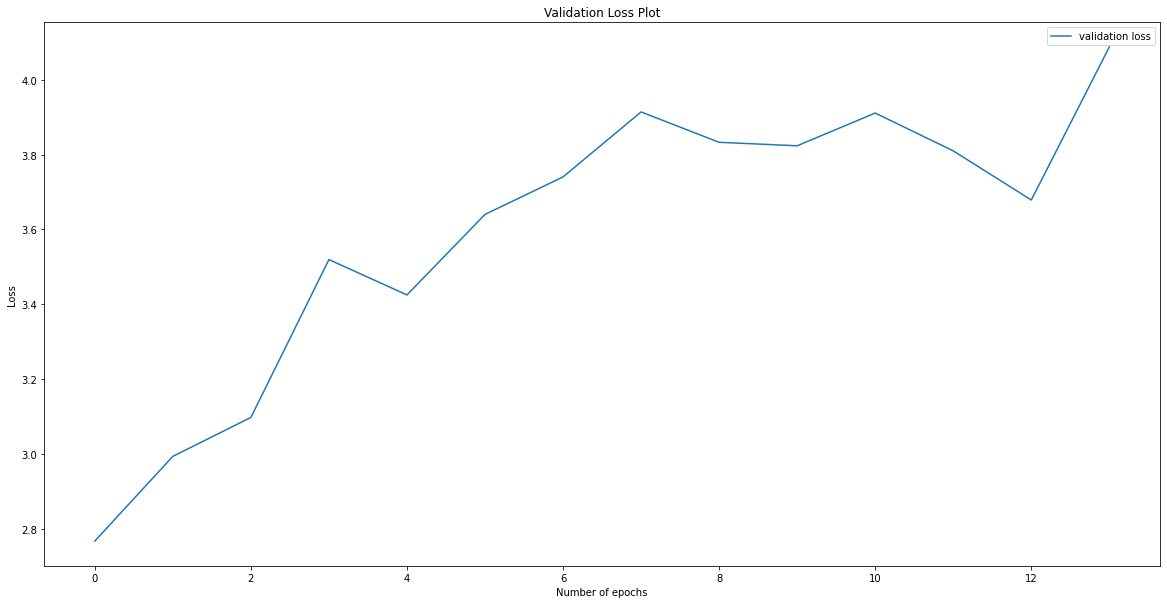

In [42]:
fig = plt.figure(figsize=(20,10))
plt.title("Validation Loss Plot")
plt.plot(validationLossTransfer, label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

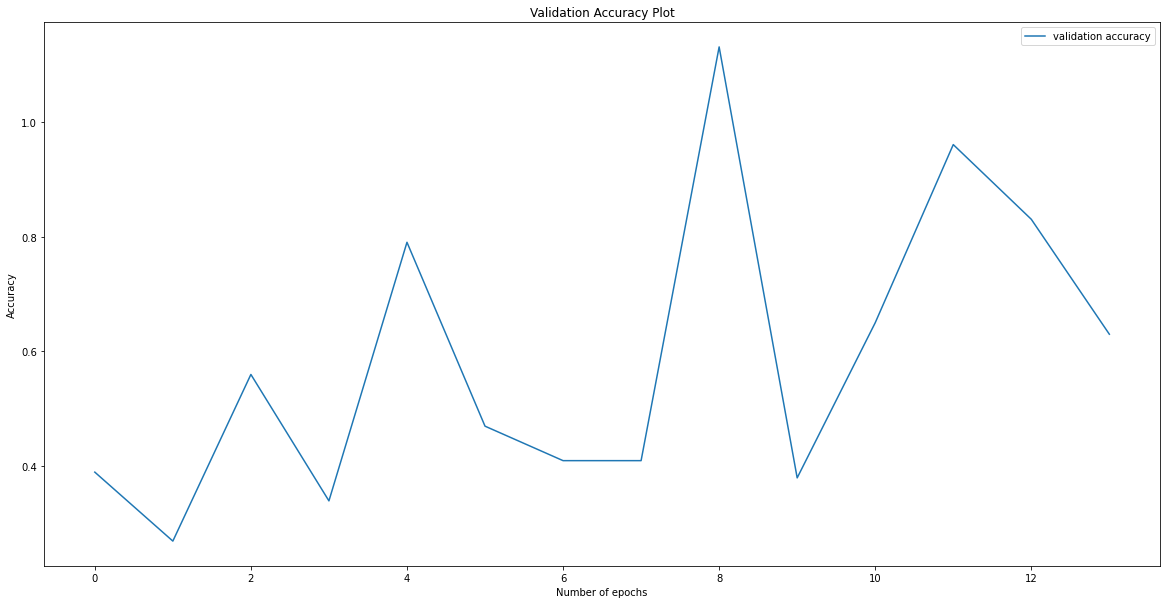

In [43]:

fig = plt.figure(figsize=(20,10))
plt.title("Validation Accuracy Plot")
plt.plot(validationAccuracyTransfer, label='validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')